In [1]:
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
# 对图片数据的维数进行处理，得到的数据格式为
# (batch_size,length,width,channels)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# 标准化图片到区间 [0., 1.] 内
train_images /= 255.
test_images /= 255.

# 二值化
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [4]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
             tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
             tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
             tf.keras.layers.Flatten(),
             tf.keras.layers.Dense(latent_dim + latent_dim),]  
        )

        self.generative_net = tf.keras.Sequential(
            [tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
             tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
             tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
             tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
             tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
             tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),]  
        )



    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

In [73]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    
    # 这个函数第一步计算了正态密度函数对数形式
    # 其次，求和是沿着sample的维数进行求和
    
    log2pi = tf.math.log(2. * np.pi)
    logp = tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)
    return logp

In [74]:
def KL_loss_normal_pdf(z,mu1,logsigma1,mu2,logsigma2):
    logpz = log_normal_pdf(z, mu1, logsigma1)
    logqz_x = log_normal_pdf(z, mu2, logsigma2)
    print("logqz_x的维数",logqz_x.shape)
    KL = - tf.reduce_mean(logqz_x - logpz)
    return KL

In [75]:
def Reconstruction_error(x_g, x_label):
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_g, labels=x_label)
    logpx_z = tf.reduce_sum(cross_ent,axis=[1,2,3])
    print("logpx_z的维数",logpx_z.shape)
    error = tf.reduce_mean(logpx_z)
    return error

In [76]:
def compute_loss(model, x):
    
    mean, logvar = model.encode(x)
    
    z = model.reparameterize(mean, logvar)
    
    x_logit = model.decode(z)
    
    #自定义函数返回的就是负的KL距离
    negative_KL_loss = KL_loss_normal_pdf(z,0.,0.,mean,logvar)
    
    #这里取负号是因为本质是计算logP(x\z)，是交叉熵的负数形式
    Reconstruction_loss =  - Reconstruction_error(x_logit, x)
    
    #求最大ELBO，即求最小-ELBO，算法是梯度下降，因此取负值
    loss = - ( negative_KL_loss + Reconstruction_loss ) 
    
    return loss

In [77]:
@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [78]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [79]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

In [80]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [81]:
optimizer = tf.keras.optimizers.Adam(1e-4)
epochs = 5
latent_dim = 50
num_examples_to_generate = 16

# 保持随机向量恒定以进行生成（预测），以便更易于看到改进。
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

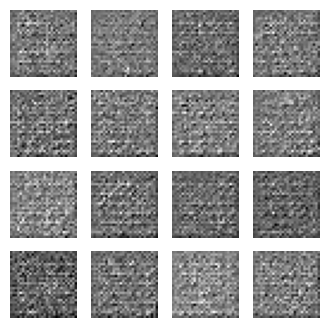

In [82]:
generate_and_save_images(model, 0, random_vector_for_generation)

In [83]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        print(train_x.shape)
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
        generate_and_save_images(model, epoch, random_vector_for_generation)

(100, 28, 28, 1)
logqz_x的维数 (100,)
logpx_z的维数 (100,)
logqz_x的维数 (100,)
logpx_z的维数 (100,)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 28, 1)
(100, 28, 

KeyboardInterrupt: 